In [1]:
from google.colab import drive
drive.mount("/content/drive")
import shutil
from google.colab import files

Mounted at /content/drive


In [2]:
import cv2
import math
import os
import numpy as np
import pandas as pd
from numpy.ma.core import ceil
from scipy.spatial import distance
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score #scoring
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import animation, colors
import matplotlib.colors as colors
from PIL import Image, ImageDraw, ImageFont
from sklearn.decomposition import PCA

In [3]:
data_path = "/content/drive/MyDrive/Location_Season_Data/"

In [4]:
df_train = pd.read_csv(data_path + "Location_Season_Pressure_first_3_year_ROI.csv")
df_train["ROI"] = df_train["Name"].apply(lambda x: x.split("_")[0] + "_" + x.split("_")[3] + "_" + x.split("_")[4])
df_train = df_train.drop_duplicates(subset = "ROI")
df_train

,0,1,2,3,4,5,6,7,8,9,...,224,225,226,227,228,season,Name,Day,Class,ROI
0,0.475692,0.473846,0.471385,0.468923,0.465846,0.462769,0.460308,0.456615,0.453538,0.450462,...,0.443077,1,1,1,0,2,116_c7_cp2_100_32,116,0,116_100_32
1,0.464615,0.463385,0.462769,0.460923,0.460308,0.457846,0.455385,0.452923,0.451077,0.450462,...,0.475077,1,0,1,0,2,125_c3_cp2_49_32,125,0,125_49_32
2,0.248615,0.243692,0.240000,0.237538,0.235692,0.234462,0.234462,0.235692,0.237538,0.240615,...,0.264615,1,0,0,0,2,120_c1_cp2_31_29,120,0,120_31_29
3,0.552000,0.544000,0.536615,0.529846,0.524923,0.521846,0.520000,0.519385,0.520615,0.523077,...,0.492923,1,1,1,0,2,127_c3_cp3_96_38,127,0,127_96_38
5,0.139692,0.139077,0.137846,0.137231,0.137231,0.137231,0.137846,0.138462,0.140308,0.142154,...,0.102769,0,1,1,0,2,100_c4_cp2_94_17,100,0,100_94_17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063,0.930833,0.935248,0.939601,0.937135,0.942242,0.940599,0.940394,0.935167,0.934217,0.936547,...,0.953185,1,0,1,1,3,997_c12_cp2_62_59,997,3,997_62_59
1064,0.869459,0.873418,0.876279,0.877193,0.879589,0.879725,0.879310,0.874263,0.870889,0.869159,...,0.919884,1,0,1,1,3,998_c12_cp2_37_48,998,2,998_37_48
1065,0.759864,0.772639,0.783731,0.791910,0.800783,0.806087,0.810837,0.810413,0.810015,0.810133,...,0.813224,1,1,1,0,3,999_c11_cp2_102_34,999,2,999_102_34
1066,0.812957,0.820837,0.826595,0.829435,0.835047,0.838979,0.843350,0.843320,0.844379,0.848008,...,0.921332,1,0,1,0,3,999_c11_cp3_37_44,999,2,999_37_44


In [5]:
df_test = pd.read_csv(data_path + "Location_Season_Pressure_ROI.csv")
df_test = df_test[df_test["Day"] > 730]
df_test = pd.concat([df_test, df_train.drop("Class", axis = 1)], ignore_index = True)
df_test["ROI"] = df_test["Name"].apply(lambda x: x.split("_")[0] + "_" + x.split("_")[3] + "_" + x.split("_")[4])
df_test = df_test.drop_duplicates(subset = "ROI")
df_test = df_test[df_test["ROI"] != "738_73_20"]
df_test

,0,1,2,3,4,5,6,7,8,9,...,223,224,225,226,227,228,season,Name,Day,ROI
0,0.904043,0.904576,0.904043,0.900097,0.896721,0.889053,0.882266,0.870825,0.863525,0.860797,...,0.914904,0.925676,1,0,0,1,2,3449_c9_cp2_29_58,3449,3449_29_58
1,0.854847,0.857352,0.859717,0.859649,0.861968,0.862052,0.863054,0.859037,0.858125,0.859321,...,0.867308,0.874035,1,1,1,1,2,3450_c8_cp2_98_50,3450,3450_98_50
2,0.886995,0.881207,0.876766,0.872807,0.872736,0.872361,0.873892,0.870334,0.865488,0.862273,...,0.921154,0.926641,1,0,1,1,2,3450_c8_cp3_59_56,3450,3450_59_56
3,0.861179,0.864167,0.866050,0.867446,0.871268,0.871870,0.872906,0.868861,0.866470,0.865224,...,0.881731,0.889479,1,1,1,1,2,3451_c8_cp2_99_50,3451,3451_99_50
4,0.915246,0.914800,0.915246,0.915205,0.919236,0.921453,0.923645,0.920432,0.918999,0.919823,...,0.946154,0.952220,1,0,1,1,2,3452_c8_cp3_55_59,3452,3452_55_59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3512,0.865846,0.877538,0.886769,0.896615,0.904615,0.910769,0.917538,0.920615,0.923692,0.926769,...,0.934769,0.936000,1,1,1,1,3,634_c11_cp3_86_58,634,634_86_58
3513,0.912615,0.915692,0.923692,0.929846,0.932308,0.935385,0.936615,0.937231,0.937231,0.936615,...,0.927385,0.928615,1,1,1,1,4,643_c12_cp2_96_62,643,643_96_62
3514,0.946462,0.944615,0.944615,0.942154,0.938462,0.932308,0.929231,0.933538,0.936615,0.936000,...,0.936000,0.939077,1,1,1,1,3,620_c11_cp2_86_60,620,620_86_60
3515,0.856000,0.864000,0.874462,0.876923,0.873846,0.864000,0.868923,0.872615,0.880615,0.889846,...,0.931077,0.927385,1,1,1,1,4,694_c17_cp2_86_63,694,694_86_63


In [6]:
df_test_1 = df_test[df_test["Day"] <= 1095]
df_test_1

,0,1,2,3,4,5,6,7,8,9,...,223,224,225,226,227,228,season,Name,Day,ROI
253,0.551875,0.559883,0.567462,0.573587,0.580029,0.585665,0.589163,0.586935,0.585174,0.582391,...,0.596154,0.591216,1,0,0,0,1,731_c12_cp1_24_27,731,731_24_27
254,0.558208,0.565239,0.571359,0.576998,0.583456,0.587138,0.589163,0.586935,0.584192,0.580915,...,0.594712,0.587355,1,0,0,0,1,732_c13_cp1_25_25,732,732_25_25
255,0.127618,0.127556,0.127131,0.127193,0.127264,0.126657,0.126108,0.124754,0.123220,0.121495,...,0.144231,0.146236,0,1,1,0,1,733_c1_cp1_83_11,733,733_83_11
256,0.173405,0.169912,0.167073,0.164230,0.161527,0.159057,0.155665,0.152750,0.148748,0.145598,...,0.204808,0.208494,0,1,1,0,1,736_c1_cp1_77_11,736,736_77_11
257,0.183634,0.177215,0.171943,0.166667,0.161527,0.157094,0.152217,0.147348,0.142366,0.137727,...,0.219231,0.231178,0,1,1,0,1,737_c1_cp1_74_14,737,737_74_14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3512,0.865846,0.877538,0.886769,0.896615,0.904615,0.910769,0.917538,0.920615,0.923692,0.926769,...,0.934769,0.936000,1,1,1,1,3,634_c11_cp3_86_58,634,634_86_58
3513,0.912615,0.915692,0.923692,0.929846,0.932308,0.935385,0.936615,0.937231,0.937231,0.936615,...,0.927385,0.928615,1,1,1,1,4,643_c12_cp2_96_62,643,643_96_62
3514,0.946462,0.944615,0.944615,0.942154,0.938462,0.932308,0.929231,0.933538,0.936615,0.936000,...,0.936000,0.939077,1,1,1,1,3,620_c11_cp2_86_60,620,620_86_60
3515,0.856000,0.864000,0.874462,0.876923,0.873846,0.864000,0.868923,0.872615,0.880615,0.889846,...,0.931077,0.927385,1,1,1,1,4,694_c17_cp2_86_63,694,694_86_63


In [7]:
X_train = df_train.drop(columns = ["225", "226", "227", "228", "season", "Name", "Day", "Class", "ROI"])
Y_train = df_train["Class"]

In [8]:
X_test = df_test.drop(columns = ["225", "226", "227", "228", "season", "Name", "Day", "ROI"])

# **SOM**

In [9]:
#Normalization
def minmax_scaler(data):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)
    return scaled
#Euclidean distance
def e_distance(x, y):
    return distance.euclidean(x, y)

#Manhanttan distance
def m_distance(x, y):
    return distance.cityblock(x, y)

#Best Matching Unit search
def winning_neuron(data, t, som, num_rows, num_cols):
  winner = [0,0]
  shortest_distance = np.sqrt(data.shape[1]) # initialise with max distance
  input_data = data[t]
  for row in range(num_rows):
    for col in range(num_cols):
      distance = e_distance(som[row][col], data[t])
      if distance < shortest_distance:
        shortest_distance = distance
        winner = [row,col]
  return winner

#Learning rate and neighbourhood range calculation
def decay(step, max_steps,max_learning_rate,max_m_dsitance):
  coefficient = 1.0 - (np.float64(step)/max_steps)
  learning_rate = coefficient*max_learning_rate
  neighbourhood_range = ceil(coefficient * max_m_dsitance)
  return learning_rate, neighbourhood_range

In [10]:
num_rows = 30
num_cols = 30
max_m_dsitance = 8
max_learning_rate = 0.4
max_steps = 20000

In [11]:
#main function

train_x_norm = minmax_scaler(X_train) # normalisation
# initialising self-organising map
num_dims = train_x_norm.shape[1] # numnber of dimensions in the input data
# som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction

# Compute PCA on the normalized training data
pca = PCA(n_components=num_dims)  # You can adjust the number of components if needed
pca.fit(train_x_norm)

# Get the top principal components
top_components = pca.components_

# Initialize SOM using PCA components
som = np.zeros((num_rows, num_cols, num_dims))  # Initialize SOM with zeros
for row in range(num_rows):
  for col in range(num_cols):
    component_index = row * num_cols + col  # Calculate the index of the component
    if component_index < num_dims:  # Make sure the index is within bounds
      som[row, col] = top_components[component_index]
    else:
      # Handle the case where you have fewer components than SOM dimensions
      # You can choose to leave the weight as zeros or use a default value
      som[row, col] = np.random.random(num_dims)  # Example of using random values

# Optionally, you can scale the initialized SOM to have a unit norm
for row in range(num_rows):
  for col in range(num_cols):
    som[row, col] /= np.linalg.norm(som[row, col])

batch_size = 20 # Define your batch size

# start training iterations
for step in range(max_steps):
  if (step+1) % 1000 == 0:
    print("Iteration: ", step+1) # print out the current iteration for every 1k
  learning_rate, neighbourhood_range = decay(step, max_steps,max_learning_rate,max_m_dsitance)

  batch_indices = np.random.choice(train_x_norm.shape[0], batch_size, replace=False)

  for t in batch_indices:
    winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
    for row in range(num_rows):
      for col in range(num_cols):
        if m_distance([row, col], winner) <= neighbourhood_range:
          som[row][col] += learning_rate * (train_x_norm[t] - som[row][col])

print("SOM training completed")

Iteration:  1000
Iteration:  2000
Iteration:  3000
Iteration:  4000
Iteration:  5000
Iteration:  6000
Iteration:  7000
Iteration:  8000
Iteration:  9000
Iteration:  10000
Iteration:  11000
Iteration:  12000
Iteration:  13000
Iteration:  14000
Iteration:  15000
Iteration:  16000
Iteration:  17000
Iteration:  18000
Iteration:  19000
Iteration:  20000
SOM training completed


In [12]:
label_data = np.array(Y_train)
map = np.empty(shape=(num_rows, num_cols), dtype=object)

for row in range(num_rows):
  for col in range(num_cols):
    map[row][col] = [] # empty list to store the label

for t in range(train_x_norm.shape[0]):
  if (t+1) % 1000 == 0:
    print("sample data: ", t+1)
  winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
  map[winner[0]][winner[1]].append(label_data[t]) # label of winning neuron

sample data:  1000


In [13]:
map_table = {}
for i in range(len(map)):
    for j in range(len(map[0])):
        if len(map[i][j]) == 0:
            map_table[i, j] = [None]
        else:
            hash_table = {}
            for k in map[i][j]:
                if k in hash_table:
                    hash_table[k] += 1
                else:
                    hash_table[k] = 1
            for key, value in hash_table.items():
                percentage = [key, round((value / len(map[i][j])), 2)]
                if (i, j) not in map_table:
                    map_table[i, j] = []
                map_table[i, j].append(percentage)


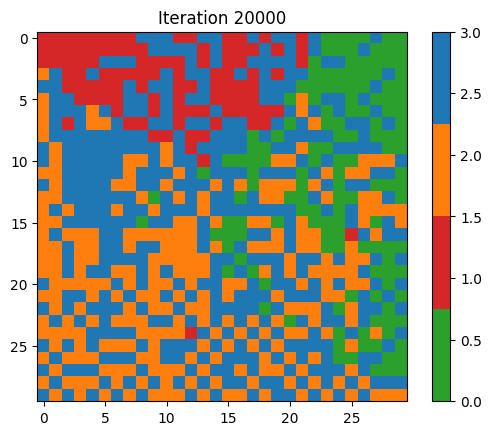

In [14]:
# construct label map
label_map = np.zeros(shape=(num_rows, num_cols),dtype=np.int64)
for row in range(num_rows):
  for col in range(num_cols):
    label_list = map[row][col]
    if len(label_list)==0:
      label = 3
    else:
      label = max(label_list, key=label_list.count)
    label_map[row][col] = label

title = ('Iteration ' + str(max_steps))
cmap = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange', 'tab:blue'])
plt.imshow(label_map, cmap=cmap)
plt.colorbar()
plt.title(title)
plt.show()

In [15]:

# test data

# using the trained som, search the winning node of corresponding to the test data
# get the label of the winning node

data_frame = minmax_scaler(X_test) # normalisation

winner_labels = []
pre_labels = []

for t in range(data_frame.shape[0]):
  winner = winning_neuron(data_frame, t, som, num_rows, num_cols)
  row = winner[0]
  col = winner[1]
  pred = map_table[row, col]
  predicted = label_map[row][col]
  pre_labels.append(pred)
  winner_labels.append(predicted)

In [16]:
SOM_test_df = df_test.copy()
SOM_test_df["Class"] = winner_labels
SOM_test_df["Percentage"] = pre_labels
SOM_test_df


#Replace the numeric values with the corresponding labels
label_mapping  = {0: "CL", 1: "COH", 2: "COL", 3: "NROI"}
SOM_test_df['Percentage'] = SOM_test_df['Percentage'].apply(lambda x: [["NROI", 1.0]] if x == [None] else x)
SOM_test_df['Percentage'] = SOM_test_df['Percentage'].apply(lambda x: [[label_mapping.get(val[0], val[0]), val[1]] for val in x])

# Print the updated DataFrame
SOM_test_df

,0,1,2,3,4,5,6,7,8,9,...,225,226,227,228,season,Name,Day,ROI,Class,Percentage
0,0.904043,0.904576,0.904043,0.900097,0.896721,0.889053,0.882266,0.870825,0.863525,0.860797,...,1,0,0,1,2,3449_c9_cp2_29_58,3449,3449_29_58,2,"[[COL, 1.0]]"
1,0.854847,0.857352,0.859717,0.859649,0.861968,0.862052,0.863054,0.859037,0.858125,0.859321,...,1,1,1,1,2,3450_c8_cp2_98_50,3450,3450_98_50,3,"[[NROI, 1.0]]"
2,0.886995,0.881207,0.876766,0.872807,0.872736,0.872361,0.873892,0.870334,0.865488,0.862273,...,1,0,1,1,2,3450_c8_cp3_59_56,3450,3450_59_56,3,"[[NROI, 1.0]]"
3,0.861179,0.864167,0.866050,0.867446,0.871268,0.871870,0.872906,0.868861,0.866470,0.865224,...,1,1,1,1,2,3451_c8_cp2_99_50,3451,3451_99_50,3,"[[NROI, 1.0]]"
4,0.915246,0.914800,0.915246,0.915205,0.919236,0.921453,0.923645,0.920432,0.918999,0.919823,...,1,0,1,1,2,3452_c8_cp3_55_59,3452,3452_55_59,3,"[[NROI, 1.0]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3512,0.865846,0.877538,0.886769,0.896615,0.904615,0.910769,0.917538,0.920615,0.923692,0.926769,...,1,1,1,1,3,634_c11_cp3_86_58,634,634_86_58,3,"[[NROI, 1.0]]"
3513,0.912615,0.915692,0.923692,0.929846,0.932308,0.935385,0.936615,0.937231,0.937231,0.936615,...,1,1,1,1,4,643_c12_cp2_96_62,643,643_96_62,3,"[[NROI, 1.0]]"
3514,0.946462,0.944615,0.944615,0.942154,0.938462,0.932308,0.929231,0.933538,0.936615,0.936000,...,1,1,1,1,3,620_c11_cp2_86_60,620,620_86_60,3,"[[NROI, 1.0]]"
3515,0.856000,0.864000,0.874462,0.876923,0.873846,0.864000,0.868923,0.872615,0.880615,0.889846,...,1,1,1,1,4,694_c17_cp2_86_63,694,694_86_63,1,"[[COH, 1.0]]"


In [17]:
SOM_test_df[SOM_test_df["Class"] == 3]

,0,1,2,3,4,5,6,7,8,9,...,225,226,227,228,season,Name,Day,ROI,Class,Percentage
1,0.854847,0.857352,0.859717,0.859649,0.861968,0.862052,0.863054,0.859037,0.858125,0.859321,...,1,1,1,1,2,3450_c8_cp2_98_50,3450,3450_98_50,3,"[[NROI, 1.0]]"
2,0.886995,0.881207,0.876766,0.872807,0.872736,0.872361,0.873892,0.870334,0.865488,0.862273,...,1,0,1,1,2,3450_c8_cp3_59_56,3450,3450_59_56,3,"[[NROI, 1.0]]"
3,0.861179,0.864167,0.866050,0.867446,0.871268,0.871870,0.872906,0.868861,0.866470,0.865224,...,1,1,1,1,2,3451_c8_cp2_99_50,3451,3451_99_50,3,"[[NROI, 1.0]]"
4,0.915246,0.914800,0.915246,0.915205,0.919236,0.921453,0.923645,0.920432,0.918999,0.919823,...,1,0,1,1,2,3452_c8_cp3_55_59,3452,3452_55_59,3,"[[NROI, 1.0]]"
5,0.886020,0.885102,0.886020,0.885965,0.886442,0.886598,0.886700,0.880157,0.872852,0.867191,...,1,1,1,1,2,3453_c7_cp2_83_54,3453,3453_83_54,3,"[[NROI, 1.0]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3510,0.905231,0.907692,0.909538,0.907692,0.907077,0.904000,0.899692,0.892923,0.885538,0.880000,...,1,1,1,1,4,636_c11_cp2_100_54,636,636_100_54,3,"[[NROI, 1.0]]"
3511,0.945231,0.947692,0.948923,0.948923,0.948923,0.948308,0.945231,0.940923,0.936615,0.933538,...,1,1,1,1,3,631_c11_cp2_89_56,631,631_89_56,3,"[[NROI, 1.0]]"
3512,0.865846,0.877538,0.886769,0.896615,0.904615,0.910769,0.917538,0.920615,0.923692,0.926769,...,1,1,1,1,3,634_c11_cp3_86_58,634,634_86_58,3,"[[NROI, 1.0]]"
3513,0.912615,0.915692,0.923692,0.929846,0.932308,0.935385,0.936615,0.937231,0.937231,0.936615,...,1,1,1,1,4,643_c12_cp2_96_62,643,643_96_62,3,"[[NROI, 1.0]]"


In [18]:
testing = SOM_test_df[SOM_test_df["Day"] <= 1095]
testing.sort_values(by = "Name")

,0,1,2,3,4,5,6,7,8,9,...,225,226,227,228,season,Name,Day,ROI,Class,Percentage
2274,0.864588,0.866602,0.869459,0.871832,0.876163,0.879234,0.880788,0.876719,0.873343,0.870635,...,1,0,1,1,4,1001_c12_cp2_63_48,1001,1001_63_48,3,"[[NROI, 0.67], [COL, 0.33]]"
2275,0.894788,0.890944,0.886508,0.881579,0.878610,0.873343,0.867980,0.857073,0.847324,0.840630,...,1,0,1,0,4,1002_c11_cp2_41_44,1002,1002_41_44,2,"[[COL, 1.0]]"
2276,0.870434,0.883155,0.895762,0.906920,0.919726,0.929799,0.939409,0.941552,0.944035,0.946877,...,1,0,0,1,4,1002_c15_cp1_20_48,1002,1002_20_48,1,"[[COH, 1.0]]"
2277,0.934730,0.930867,0.926936,0.922027,0.920215,0.916053,0.912315,0.903242,0.896416,0.892277,...,1,0,1,1,4,1003_c11_cp2_38_48,1003,1003_38_48,2,"[[COL, 1.0]]"
2279,0.909888,0.910906,0.911349,0.909357,0.909447,0.907707,0.906404,0.899804,0.895434,0.894245,...,1,0,0,1,4,1004_c10_cp2_30_49,1004,1004_30_49,2,"[[COL, 1.0]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551,0.869459,0.873418,0.876279,0.877193,0.879589,0.879725,0.879310,0.874263,0.870889,0.869159,...,1,0,1,1,3,998_c12_cp2_37_48,998,998_37_48,3,"[[NROI, 0.5], [COL, 0.5]]"
552,0.759864,0.772639,0.783731,0.791910,0.800783,0.806087,0.810837,0.810413,0.810015,0.810133,...,1,1,1,0,3,999_c11_cp2_102_34,999,999_102_34,2,"[[COL, 1.0]]"
553,0.812957,0.820837,0.826595,0.829435,0.835047,0.838979,0.843350,0.843320,0.844379,0.848008,...,1,0,1,0,3,999_c11_cp3_37_44,999,999_37_44,2,"[[COL, 1.0]]"
554,0.866537,0.870010,0.872869,0.875244,0.879099,0.882671,0.881773,0.877210,0.869907,0.864240,...,1,0,1,0,3,999_c14_cp1_53_37,999,999_53_37,3,"[[NROI, 1.0]]"


In [19]:
labels_df = df_train.sort_values(by = "Name")
labels_df

,0,1,2,3,4,5,6,7,8,9,...,224,225,226,227,228,season,Name,Day,Class,ROI
737,0.864588,0.866602,0.869459,0.871832,0.876163,0.879234,0.880788,0.876719,0.873343,0.870635,...,0.903958,1,0,1,1,4,1001_c12_cp2_63_48,1001,3,1001_63_48
738,0.894788,0.890944,0.886508,0.881579,0.878610,0.873343,0.867980,0.857073,0.847324,0.840630,...,0.880309,1,0,1,0,4,1002_c11_cp2_41_44,1002,2,1002_41_44
739,0.870434,0.883155,0.895762,0.906920,0.919726,0.929799,0.939409,0.941552,0.944035,0.946877,...,0.923263,1,0,0,1,4,1002_c15_cp1_20_48,1002,1,1002_20_48
740,0.934730,0.930867,0.926936,0.922027,0.920215,0.916053,0.912315,0.903242,0.896416,0.892277,...,0.920849,1,0,1,1,4,1003_c11_cp2_38_48,1003,2,1003_38_48
741,0.909888,0.910906,0.911349,0.909357,0.909447,0.907707,0.906404,0.899804,0.895434,0.894245,...,0.910232,1,0,0,1,4,1004_c10_cp2_30_49,1004,2,1004_30_49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1064,0.869459,0.873418,0.876279,0.877193,0.879589,0.879725,0.879310,0.874263,0.870889,0.869159,...,0.919884,1,0,1,1,3,998_c12_cp2_37_48,998,2,998_37_48
1065,0.759864,0.772639,0.783731,0.791910,0.800783,0.806087,0.810837,0.810413,0.810015,0.810133,...,0.813224,1,1,1,0,3,999_c11_cp2_102_34,999,2,999_102_34
1066,0.812957,0.820837,0.826595,0.829435,0.835047,0.838979,0.843350,0.843320,0.844379,0.848008,...,0.921332,1,0,1,0,3,999_c11_cp3_37_44,999,2,999_37_44
1067,0.866537,0.870010,0.872869,0.875244,0.879099,0.882671,0.881773,0.877210,0.869907,0.864240,...,0.893340,1,0,1,0,3,999_c14_cp1_53_37,999,1,999_53_37


In [20]:
true_labels = np.array(testing["Class"])
predicted_labels = np.array(labels_df["Class"])

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

matrix = confusion_matrix(true_labels, predicted_labels)
print(matrix)

Accuracy: 0.30078895463510846
[[ 79  47 108  14]
 [ 32  67  92  37]
 [ 98  73 113  50]
 [ 43  51  64  46]]


In [21]:
SOM_ROI = {}

data = SOM_test_df.to_numpy()
for item in data:
    part = item[230].split("_")
    day = int(part[0])
    x = int(part[3])
    y = int(part[4])
    category = item[233]
    percentage = item[234]
    if day in SOM_ROI:
        found_duplicate = False
        for ele in SOM_ROI[day]:
            if x == ele[0] and y == ele[1]:
                found_duplicate = True
                break
        if not found_duplicate:
            SOM_ROI[day].append([x, y, category, percentage])
    else:
        SOM_ROI[day] = [[x, y, category, percentage]]


In [ ]:
folder_name = "10_years_SOM_Categorical_Pressure_ROI_Image"
SOM_folder_path = "/content/drive/MyDrive/" + folder_name

os.makedirs(SOM_folder_path)

In [ ]:
image_path = "/content/drive/MyDrive/Pressure_raw_Image"
color_list = {0: (0, 255, 0), 1: (0, 0, 255), 2: (0, 255, 255), 3: (255, 0, 0)}
default_color = (0, 0, 0)
font_size = 6
font_path = "/content/Roboto-Bold.ttf"
font = ImageFont.truetype(font_path, font_size)
text_color = (148, 91, 10)
background_color = (255, 255, 255)

In [ ]:
for file in os.listdir(image_path):
    file_path = os.path.join(image_path, file)
    image = cv2.imread(file_path)

    file_name = os.path.splitext(file)[0]
    number = int(file_name[3:])
    height, width, _ = image.shape

    white_image = Image.new("RGB", (width, height), background_color)

    if number in SOM_ROI:
        num = 1
        text_pos = (5,5)
        for point in SOM_ROI[number]:
            #Add point to the image
            x = point[0]
            y = point[1]
            color = color_list[point[2]]
            size = 2
            vertices = np.array([(x, y - size), (x - size, y), (x, y + size), (x + size, y)])
            cv2.drawContours(image, [vertices.reshape((-1, 1, 2))], -1, color, thickness=cv2.FILLED)
            num_pos = (x + 3, y - 2)
            num_font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.2
            line_thickness = 0
            cv2.putText(image, str(num), num_pos, num_font, font_scale, text_color, line_thickness)

            # Add text into white image
            text = str(num) + ": "
            if point[3] is not None:
                text = text + ", ".join([f"{a}:{b}" for a, b in point[3]])

            draw = ImageDraw.Draw(white_image)
            draw.text(text_pos, text, fill = default_color, font = font)

            text_pos = (text_pos[0], text_pos[1] + 11)
            num += 1

        final_img = np.concatenate((image, white_image), axis = 0)
        cv2.imwrite(SOM_folder_path + "/day" + str(number) + ".png", final_img)


